# Bigram Language Model

This notebook demonstrates an implementation and usage of a simple bigram language model.
A bigram model is a super simple form of language models, predicting the next token
based only on the current token.

## Dataset
- For this lesson (and a few others) we will be using a slice of the [arXiv Dataset](https://www.kaggle.com/datasets/Cornell-University/arxiv). 
- We've collected ~51,000 paper summaries and will be training our bigram model using this subset.
- The dataset is stored in src/datasets/arxiv_data.csv

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

## Loading and Exploring the Data

We start by loading our dataset of arXiv paper summaries and exploring its structure.

In [ ]:
# Load the (sliced) ArXiv dataset
dataset = load_dataset(path="../../src/datasets/")

# Display a few examples to understand the data structure
print("Dataset structure:")
print(pd.DataFrame(dataset["train"]).head())

# Join all summaries into a single string for training
data_str = "\n".join(dataset["train"]["summaries"])

# Split into training and testing sets (90/10 split)
len_train = int(0.9*len(data_str))
train_data = data_str[:len_train]
test_data = data_str[len_train:]

# Show an example of the data
print("\nExample summary:")
print(train_data[:500])

## Tokenization

Tokenization is the process of converting text into numerical tokens that can be processed by our model.
For our character-level bigram model, we'll tokenize at the character level, assigning a unique integer to each character.

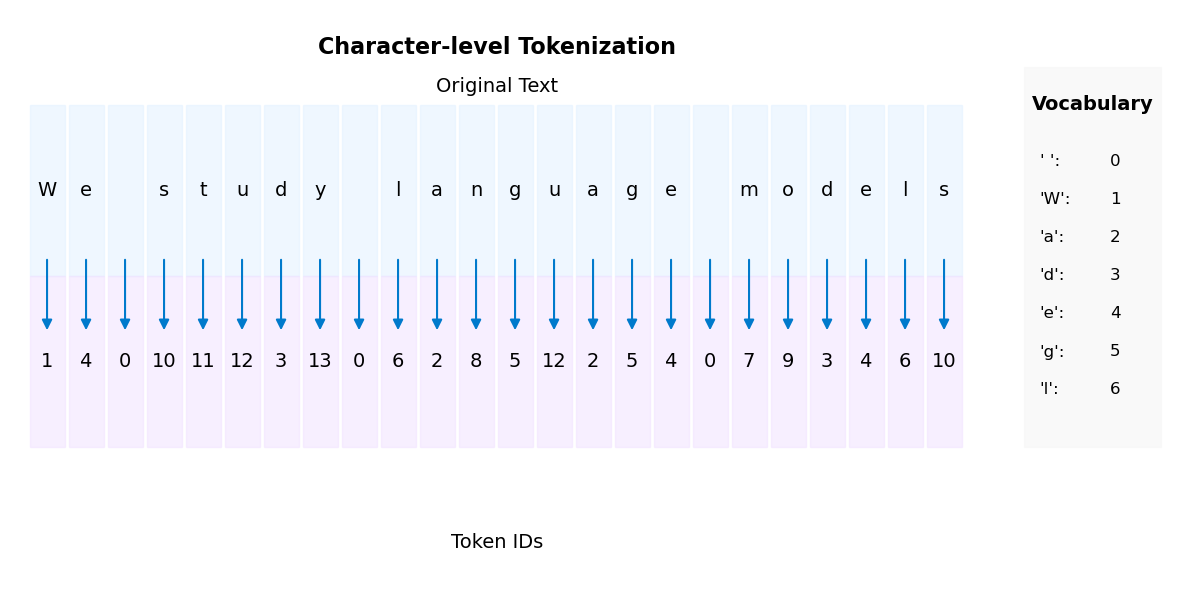

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyArrowPatch

fig, ax = plt.subplots(figsize=(12, 6))
text = "We study language models"

chars = sorted(list(set(text + " ")))
str_to_i = {ch: i for i, ch in enumerate(chars)}

tokens = [str_to_i[ch] for ch in text]
for i, char in enumerate(text):
    # Add character with box
    ax.add_patch(Rectangle((i, 0.6), 0.9, 0.9, fill=True, color='#e0f0ff', alpha=0.5))
    ax.text(i + 0.45, 1.05, char, ha='center', va='center', fontsize=14)

for i, token in enumerate(tokens):
    # Add token with box
    ax.add_patch(Rectangle((i, -0.3), 0.9, 0.9, fill=True, color='#f0e0ff', alpha=0.5))
    ax.text(i + 0.45, 0.15, str(token), ha='center', va='center', fontsize=14)

# Add arrows connecting characters to tokens
for i in range(len(text)):
    arrow = FancyArrowPatch((i + 0.45, 0.7), (i + 0.45, 0.3), 
                          arrowstyle='-|>', mutation_scale=15, 
                          color='#007acc', linewidth=1.5)
    ax.add_patch(arrow)

# Add vocabulary display on the side
vocab_x = len(text) + 1.5
ax.add_patch(Rectangle((vocab_x, -0.3), 3.5, 2, fill=True, color='#f5f5f5', alpha=0.5))
ax.text(vocab_x + 1.75, 1.5, "Vocabulary", ha='center', va='center', fontsize=14, fontweight='bold')

for i, (char, idx) in enumerate(sorted(str_to_i.items())):
    y_pos = 1.2 - (i * 0.2)
    if y_pos < -0.2:
        continue  # Skip if we run out of space
    ax.text(vocab_x + 0.4, y_pos, f"'{char}':", ha='left', va='center', fontsize=12)
    ax.text(vocab_x + 2.2, y_pos, f"{idx}", ha='left', va='center', fontsize=12)

# Add title and labels
ax.text(len(text)/2, 1.8, "Character-level Tokenization", ha='center', va='center', fontsize=16, fontweight='bold')
ax.text(len(text)/2, -0.8, "Token IDs", ha='center', va='center', fontsize=14)
ax.text(len(text)/2, 1.6, "Original Text", ha='center', va='center', fontsize=14)

# Set axis limits and remove ticks
ax.set_xlim(-0.5, vocab_x + 4)
ax.set_ylim(-1, 2)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

plt.tight_layout()
plt.savefig('tokenization_diagram.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Find all unique characters in our dataset
chars = sorted(list(set(train_data+test_data)))
vocab_size = len(chars)
print('All characters used:', ''.join(chars))
print('\nNumber of unique characters:', vocab_size)

# Create mapping dictionaries between characters and integers
str_to_i = {ch: i for i, ch in enumerate(chars)}
i_to_str = {i: ch for i, ch in enumerate(chars)}

def encode(s):
    """Convert a string to a list of integers based on our character mapping."""
    return [str_to_i[ch] for ch in s]

def decode(nums):
    """Convert a list of integers back to a string using our character mapping."""
    return ''.join(i_to_str[i] for i in nums)

# Test our encoding/decoding functions
print("\nEncoding 'hello':", encode("hello"))
print("Decoding back:", decode(encode("hello")))

## Preparing the Data for Training

We'll convert our text data into PyTorch tensors for efficient processing during training.

In [ ]:
# Encode the entire dataset into tensors
train_encoded = torch.tensor(encode(train_data), dtype=torch.long)
test_encoded = torch.tensor(encode(test_data), dtype=torch.long)
print("Training data shape:", train_encoded.shape, train_encoded.dtype)
print("First 100 tokens:", train_encoded[:100])

# Define our context window size (block_size)
block_size = 8
print("\nExample context window:", train_encoded[:block_size+1])

## Creating Training Batches

To train our model efficiently, we'll create batches of data with inputs and their corresponding targets.

In [ ]:
# Function to generate random batches from our dataset
batch_size = 4  # Number of sequences in a batch
block_size = 8  # Length of each sequence

def get_batch(split):
    """
    Generate a small batch of data for training or evaluation.
    
    Args:
        split: Either 'train' or 'test' to determine which dataset to sample from
        
    Returns:
        x: Input sequences (B, T)
        y: Target sequences (B, T) - shifted by 1 position
    """
    # Choose the appropriate dataset
    data = train_encoded if split == "train" else test_encoded
    
    # Generate random starting indices
    ix = torch.randint(len(data) - block_size, (batch_size,))
    
    # Extract sequences of length block_size
    x = torch.stack([data[i:i+block_size] for i in ix])
    
    # Target is the next character in the sequence (shifted by 1)
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    
    return x, y

# Test our batch generation
xb, yb = get_batch('train')
print("Input batch shape:", xb.shape)
print("Inputs:\n", xb)
print("\nTargets:\n", yb)

## Bigram Language Model Implementation

Now we'll implement our bigram language model. This model predicts the next character based solely on the current character.

In [ ]:
class BigramLanguageModel:
    def __init__(self, vocab_size):
        """
        Initialize the bigram language model.
        
        Args:
            vocab_size: Size of the vocabulary (number of unique characters)
        """
        # Create a lookup table of size vocab_size x vocab_size
        # This table represents the probability of transitioning from one character to another
        self.token_embedding_table = torch.randn((vocab_size, vocab_size), requires_grad=True)
    
    def forward(self, idx):
        """
        Forward pass of the model.
        
        Args:
            idx: Batch of sequences (B, T)
            
        Returns:
            logits: Prediction scores for next character (B, T, C)
        """
        # For each position in the sequence, look up the embedding for that character
        # This gives us the logits (unnormalized probabilities) for the next character
        logits = self.token_embedding_table[idx]  # (B, T, C)
        return logits
    
    def parameters(self):
        """Return the parameters of the model for optimization."""
        return [self.token_embedding_table]
    
    def generate(self, idx, max_new_tokens):
        """
        Generate new text by sampling from the model's predictions.
        
        Args:
            idx: Starting sequence (B, T)
            max_new_tokens: Number of new tokens to generate
            
        Returns:
            idx: Extended sequence with generated tokens (B, T+max_new_tokens)
        """
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # Get the predictions
            logits = self.forward(idx)  # (B, T, C)
            
            # Focus only on the last time step
            logits = logits[:, -1, :]  # (B, C)
            
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            
            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
            
        return idx

## Training the Model

We'll define our loss function and training loop to optimize the model's parameters.

In [ ]:
# Initialize the model
model = BigramLanguageModel(vocab_size)

# Test the model's forward pass
xb, yb = get_batch('train')
logits = model.forward(xb)
print(f"Input shape: {xb.shape}")
print(f"Output logits shape: {logits.shape}")

def loss_fn(logits, targets):
    """
    Calculate the cross-entropy loss between predictions and targets.
    
    Args:
        logits: Prediction scores (B, T, C)
        targets: Target indices (B, T)
        
    Returns:
        loss: Scalar loss value
    """
    B, T, C = logits.shape
    logits = logits.view(B*T, C)  # Reshape for cross_entropy
    targets = targets.view(B*T)   # Reshape to match
    loss = F.cross_entropy(logits, targets)
    return loss

# Calculate initial loss
loss = loss_fn(logits, yb)
print(f"Initial loss: {loss.item()}")

# Generate some text before training
idx = torch.zeros((1, 1), dtype=torch.long)
print("\nText generated before training:")
generated_text = model.generate(idx, max_new_tokens=100)[0]
print(decode(generated_text.tolist()))

## Training Loop

Now we'll train our model by repeatedly sampling batches and updating the parameters.

In [ ]:
# Setup optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

def train(model, epochs=10000, eval_interval=1000):
    """
    Train the bigram language model.
    
    Args:
        model: The BigramLanguageModel instance
        epochs: Number of training iterations
        eval_interval: How often to evaluate and print progress
    """
    for i in range(epochs):
        # Sample a batch of data
        xb, yb = get_batch('train')
        
        # Evaluate the loss
        logits = model.forward(xb)
        loss = loss_fn(logits, yb)
        
        # Zero gradients
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Update parameters
        optimizer.step()
        
        # Print progress
        if i % eval_interval == 0:
            print(f"Step {i}: Loss {loss.item():.4f}")
            
            # Generate some text
            if i % (eval_interval * 10) == 0:
                idx = torch.zeros((1, 1), dtype=torch.long)
                generated = model.generate(idx, max_new_tokens=100)[0]
                print(decode(generated.tolist()))
                print('-' * 80)

# Train the model
print("Training the model...")
train(model, epochs=10000, eval_interval=1000)

## Generating Text with the Trained Model

Let's generate a longer piece of text with our trained model to see what it has learned.

In [ ]:
# Generate a longer text sample
print("\nGenerating text with the trained model:")
idx = torch.zeros((1, 1), dtype=torch.long)
generated_text = model.generate(idx, max_new_tokens=500)[0]
print(decode(generated_text.tolist()))

## Conclusion

We've implemented a simple bigram language model that learns to predict the next character based on the current character.
While this model is very limited (it only looks at the previous character), it demonstrates the fundamental concepts
of statistical language modeling and serves as a foundation for more complex models.

Key limitations of the bigram model:
1. Limited context - only considers the immediately preceding character
2. Cannot capture long-range dependencies in language
3. Generates text that may look somewhat like the training data but lacks coherence

In the next lessons, we'll explore more sophisticated models that can capture longer contexts and generate more coherent text.